In [1]:
!pip -q install ../python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np

single_agent = False

if single_agent: #One agent environment
    env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')
else: #20 agent environment
    env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

#examine rewards
rewards = env_info.rewards
print("Rewards shape: ", len(rewards))
print(rewards)

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]
Rewards shape:  20
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_running_avg(scores, window=100):
    """
    Plots the running average of desired window size
        ARGS:
            scores(list):= list of episodic rewards
            window(int):= size of the window the average will be computed over
    """
    scores = np.array(scores)
    N = len(scores)
    running_avg = np.empty(N)
    thresh = np.array([30 for i in range(len(scores))])
    ax = np.arange(0, len(scores))
    
    for t in range(N):
        running_avg[t] = scores[max(0, t-window):t+1].mean()
    
    plt.plot(ax, running_avg, ax, thresh)
    plt.title("Running Average ({}) Score".format(window))
    plt.savefig("td3pg_scores_running100_mean.pdf", dpi=1600)
    plt.show()

In [6]:
from collections import deque
from agent import Agent

RESULTS = [] #Used in the event of keyboard exit so results can still be visually examined

#Only effects training if single_agent = False
SINGLE_ACTOR = True #True => 1 agent controlling 20 arms; False => 20 agents controlling 1 arm each

def train(env, n_episodes, seed):
    scores_list = []
    scores_window = deque(maxlen=100)
    epsilon = 1.0
    
    if not SINGLE_ACTOR:
        agents = [Agent(state_size, action_size, seed) for _ in range(num_agents)]
    else:
        agent = Agent(state_size, action_size, seed)
    
    for e in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]        
        states = env_info.vector_observations                 
        scores = np.zeros(num_agents) 
        
        if not SINGLE_ACTOR:
            for agent in agents:
                agent.reset()
        else:
            agent.reset()
        
        epsilon = max((epsilon * np.exp(-0.005 * e)), 0.01)
        
        while True:
            if not SINGLE_ACTOR:
                actions = [agents[i].act(states[i], epsilon) for i in range(num_agents)] 
            else:
                actions = [agent.act(states[i], epsilon) for i in range(num_agents)]
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done
            
            if not SINGLE_ACTOR:
                for i in range(num_agents):
                    agents[i].step(states, actions, rewards, next_states, dones)
            else:
                agent.step(states, actions, rewards, next_states, dones)

            scores += env_info.rewards                         
            states = next_states  

            if np.any(dones):                                  
                break
                
        mean_scores = np.mean(scores)        
        scores_list.append(mean_scores)
        scores_window.append(mean_scores)
        
        print("Episode {}:\tEpisode Score {:.4f}\tRunning Mean Score {:.4f}\tEpsilon {:.4f}".format(e+1,
                                                                                                    mean_scores,
                                                                                                    np.mean(scores_window),
                                                                                                    epsilon
                                                                                                   ))
        
        if np.mean(scores_window) >= 30.0 and ((e+1) >= 100):
            print(f"Agent solved environment in {e+1} episodes!")
            break
        
        global RESULTS
        RESULTS.append(mean_scores)
    
    if not SINGLE_ACTOR:
        return scores_list, agents
    else:
        return scores_list, agent

In [7]:
from workspace_utils import active_session

In [8]:
with active_session():
    results, agent = train(env, 1000, seed=628)

Episode 1:	Episode Score 0.8105	Running Mean Score 0.8105	Epsilon 1.0000
Episode 2:	Episode Score 0.8195	Running Mean Score 0.8150	Epsilon 0.9950
Episode 3:	Episode Score 0.9385	Running Mean Score 0.8562	Epsilon 0.9851
Episode 4:	Episode Score 1.4540	Running Mean Score 1.0056	Epsilon 0.9704
Episode 5:	Episode Score 2.1865	Running Mean Score 1.2418	Epsilon 0.9512
Episode 6:	Episode Score 3.3525	Running Mean Score 1.5936	Epsilon 0.9277
Episode 7:	Episode Score 4.9470	Running Mean Score 2.0726	Epsilon 0.9003
Episode 8:	Episode Score 5.2830	Running Mean Score 2.4739	Epsilon 0.8694
Episode 9:	Episode Score 5.5585	Running Mean Score 2.8167	Epsilon 0.8353
Episode 10:	Episode Score 5.8205	Running Mean Score 3.1170	Epsilon 0.7985
Episode 11:	Episode Score 8.7965	Running Mean Score 3.6334	Epsilon 0.7596
Episode 12:	Episode Score 9.3735	Running Mean Score 4.1117	Epsilon 0.7189
Episode 13:	Episode Score 9.1430	Running Mean Score 4.4987	Epsilon 0.6771
Episode 14:	Episode Score 12.1715	Running Mean 

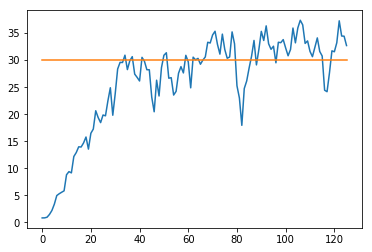

In [9]:
ax = np.arange(0,len(RESULTS))
thresh = np.array([30 for i in range(len(RESULTS))])
plt.plot(ax, RESULTS, ax, thresh)
plt.savefig("td3pg_scores.pdf", dpi=1600)
plt.show()

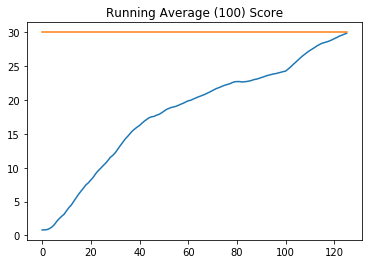

In [10]:
plot_running_avg(RESULTS)

In [11]:
import torch

torch.save(agent.act_local.state_dict(), 'trained_actor_model.pth')
torch.save(agent.crt_local_1.state_dict(), 'trained_critic_model_1.pth')
torch.save(agent.crt_local_2.state_dict(), 'trained_critic_model_2.pth')

In [12]:
env.close()